# Dictionary indexing of EBSD patterns from an Al-Mn alloy

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

See the relevant package documentation for more details on the packages used here:
* kikuchipy: https://kikuchipy.org/en/stable/
* orix: https://orix.readthedocs.io/en/stable/

Import required packages and print their versions

In [1]:
# Replace "inline" with "qt5" from the pyqt package for interactive plotting
%matplotlib inline

from datetime import date
import importlib_metadata
import os

import dask
import kikuchipy as kp
import matplotlib.pyplot as plt
import numpy as np
from orix import io, plot, sampling
from orix.vector import Vector3d


# Directories
dset_no = 1
dir_user = "C:/Users/hakonwii"
dir_mp = os.path.join(dir_user, "ebsd_simulations")
dir_data = os.path.join(dir_user, "p/300c", str(dset_no))

# Matplotlib
plt.rcParams["font.size"] = 12
savefig_kwds = dict(bbox_inches="tight", pad_inches=0, dpi=150)

print("Run date: ", date.today())
print("\nSoftware versions\n------------------")
for pkg in ["dask", "kikuchipy", "matplotlib", "numpy", "orix"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-05-12

Software versions
------------------
dask : 2022.5.0
kikuchipy : 0.5.7
matplotlib : 3.5.2
numpy : 1.21.6
orix : 0.8.2


## Set up indexing

Load data lazily (not into RAM)

In [2]:
s = kp.load(os.path.join(dir_data, "pattern_sda.h5"), lazy=True)
sig_shape = s.axes_manager.signal_shape[::-1]
print(s.axes_manager)

<Axes manager, axes: (919, 919|96, 96)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    919 |      0 |       0 |     0.1 |     um 
               y |    919 |      0 |       0 |     0.1 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     96 |      0 |       0 |       1 |     um 
              dy |     96 |      0 |       0 |       1 |     um 


Extract relevant metadata

In [3]:
md_sem = s.metadata.Acquisition_instrument.SEM
md_ebsd = md_sem.Detector.EBSD
sample_tilt = md_ebsd.sample_tilt  # Degrees
camera_tilt = md_ebsd.azimuth_angle  # Degrees
energy = md_sem.beam_energy  # kV

Define detector's view of the sample, using the average projection center (PC)
found from optimization with `PyEBSDIndex`

In [4]:
pcs = np.loadtxt(os.path.join(dir_data, "cal_pcs.txt"), usecols=[1, 2, 3])
pc = pcs.mean(axis=0)
print(pc)

detector = kp.detectors.EBSDDetector(
    shape=sig_shape,
    pc=pc,
    sample_tilt=sample_tilt,
    tilt=camera_tilt,
    convention="bruker",
)
detector

[0.49789041 0.22546632 0.5497445 ]


EBSDDetector (96, 96), px_size 1 um, binning 1, tilt 0.0, azimuthal 0, pc (0.498, 0.225, 0.55)

Check PC

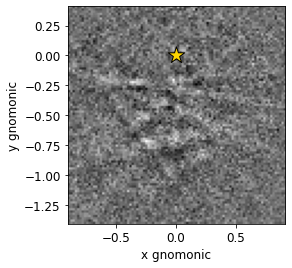

In [5]:
fig, _ = detector.plot(coordinates="gnomonic", pattern=s.inav[0, 0].data.compute(), return_fig_ax=True)
fig.savefig(os.path.join(dir_data, "detector.png"), **savefig_kwds)

Load master pattern

In [6]:
mp = kp.load(
    os.path.join(dir_mp, "al", "al_mc_mp_20kv.h5"),
    projection="lambert",
    energy=energy,
    hemisphere="north",
)
mp.phase.name = "al"

Sample orientation space

In [7]:
rot_dict = sampling.get_sample_fundamental(
    resolution=1.4,
    point_group=mp.phase.point_group,
    method="cubochoric",
)
rot_dict

Rotation (304053,)
[[ 0.8547 -0.3517 -0.3517 -0.1484]
 [ 0.8547 -0.3533 -0.3533 -0.1405]
 [ 0.8547 -0.3533 -0.3533  0.1405]
 ...
 [ 0.8547  0.3533  0.3533 -0.1405]
 [ 0.8547  0.3533  0.3533  0.1405]
 [ 0.8547  0.3517  0.3517  0.1484]]

Generate dictionary

In [8]:
sim_dict = mp.get_patterns(
    rotations=rot_dict, detector=detector, energy=energy, compute=False
)
sim_dict

C:\Users\hakonwii\Miniconda3\envs\corr-env\lib\site-packages\hyperspy\signal.py:2451: UserWarning: Setting the `metadata` attribute is deprecated and will be removed in HyperSpy 2.0. Use the `set_item` and `add_dictionary` methods of the `metadata` attribute instead.
  warnings.warn(


<LazyEBSD, title: , dimensions: (304053|96, 96)>

Create a signal mask and check it

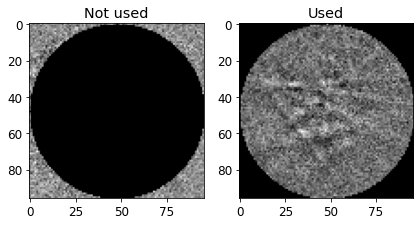

In [9]:
signal_mask = ~kp.filters.Window("circular", sig_shape).astype(bool)
p = s.inav[0, 0].data.compute()

fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.imshow(p * signal_mask, cmap="gray")
ax1.imshow(p * ~signal_mask, cmap="gray")
ax0.set_title("Not used")
ax1.set_title("Used")
fig.tight_layout()
fig.savefig(os.path.join(dir_data, "signal_mask.png"), **savefig_kwds)

## Index

In [10]:
keep_n = 20
# Setting this will be unnecessary in a future v0.6 release of kikuchipy
with dask.config.set(**{"array.slicing.split_large_chunks": False}):
    xmap = s.dictionary_indexing(
        dictionary=sim_dict,
        metric="ncc",
        keep_n=keep_n,
        signal_mask=signal_mask,
        rechunk=True,
    )
xmap

Dictionary indexing information:
	Phase name: al
	Matching 844561 experimental pattern(s) to 304053 dictionary pattern(s)
	NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: True, signal mask: True


100%|██████████| 129/129 [6:33:46<00:00, 183.15s/it]  
C:\Users\hakonwii\Miniconda3\envs\corr-env\lib\site-packages\kikuchipy\indexing\_dictionary_indexing.py:131: RuntimeWarning: overflow encountered in long_scalars
  np.floor(n_experimental * dictionary_size / total_time)


	Indexing speed: 35 patterns/s, -38378 comparisons/s


Phase     Orientations  Name  Space group  Point group  Proper point group     Color
    0  844561 (100.0%)    al        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: px

Save results to file

In [11]:
io.save(os.path.join(dir_data, "xmap.h5"), xmap)

## Inspect results

Scores map

In [12]:
scores = xmap.scores[:, 0].reshape(xmap.shape)
plt.imsave(os.path.join(dir_data, "maps_ncc1.png"), scores, cmap="gray")

Orientation similarity map

In [13]:
osm = kp.indexing.orientation_similarity_map(xmap, n_best=keep_n)
plt.imsave(os.path.join(dir_data, f"maps_osm{keep_n}.png"), osm, cmap="gray")

Both maps with colorbars

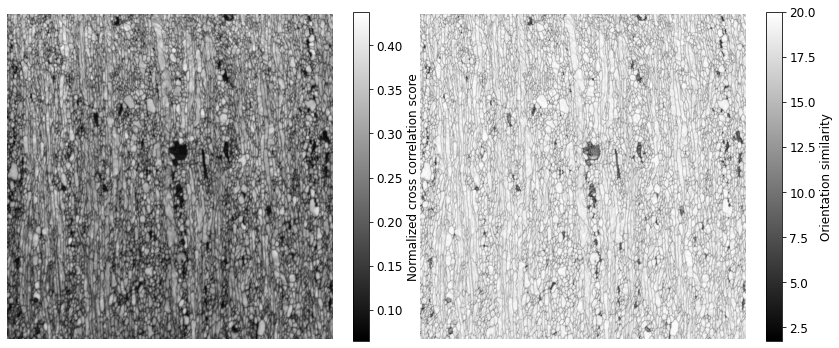

In [14]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 5), ncols=2)
im0 = ax0.imshow(scores, cmap="gray")
im1 = ax1.imshow(osm, cmap="gray")
fig.colorbar(im0, ax=ax0, label="Normalized cross correlation score")
fig.colorbar(im1, ax=ax1, label="Orientation similarity")
ax0.axis("off")
ax1.axis("off")
fig.tight_layout(w_pad=-1)
fig.savefig(os.path.join(dir_data, f"maps_ncc1_osm{keep_n}_colorbar.png"), **savefig_kwds)

Histograms of both maps

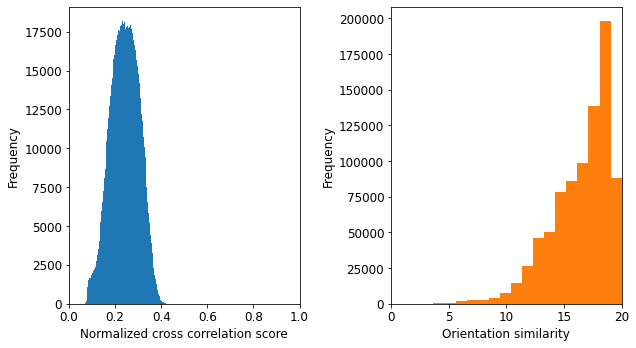

In [15]:
bins_ncc = np.linspace(scores.min(), scores.max(), 100)
bins_osm = np.linspace(osm.min(), osm.max(), keep_n)

fig, (ax0, ax1) = plt.subplots(figsize=(9, 5), ncols=2)
ax0.hist(scores.ravel(), bins_ncc, color="C0", label="NCC from DI");
ax1.hist(osm.ravel(), bins_osm, color="C1", label="OSM");
ax0.set_xlim((0, 1))
ax1.set_xlim((0, keep_n))
ax0.set_xlabel("Normalized cross correlation score")
ax1.set_xlabel("Orientation similarity")
ax0.set_ylabel("Frequency")
ax1.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(os.path.join(dir_data, f"hist_ncc1_osm{keep_n}.png"), **savefig_kwds)

Orientation maps

In [16]:
ckey = plot.IPFColorKeyTSL(xmap.phases[0].point_group)

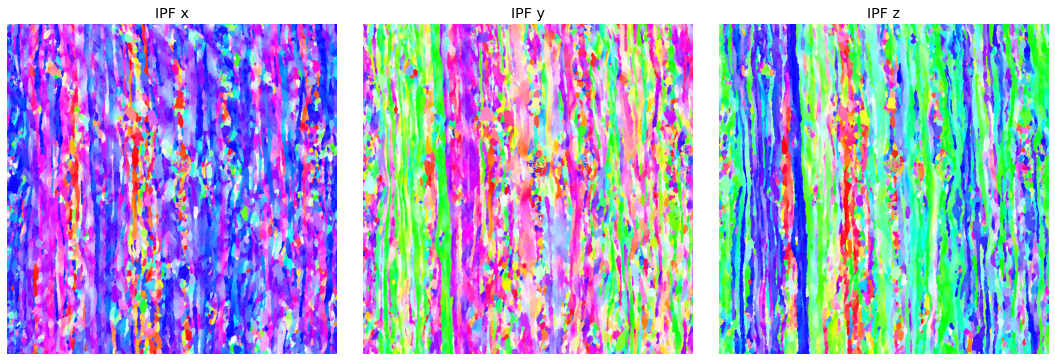

In [17]:
ori = xmap.orientations
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
for ax, v, title in zip(axes, directions, ("x", "y", "z")):
    ckey.direction = v
    rgb = ckey.orientation2color(ori).reshape(xmap.shape + (3,))
    plt.imsave(os.path.join(dir_data, f"maps_ipf{title}.png"), rgb)
    ax.imshow(rgb)
    ax.axis("off")
    ax.set_title(f"IPF {title}")
fig.tight_layout()
fig.savefig(os.path.join(dir_data, "maps_ipf.png"), **savefig_kwds)